# Final Project 
================================================================================================================

**TEAM**: Star Li, Zheng Zhang, Stefan Li

## Setup

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LassoCV, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

### Loading in the Data

In [2]:
data_state = pd.read_csv('final_proj_data/covid19/4.18states.csv')
data_counties = pd.read_csv('final_proj_data/covid19/abridged_couties.csv')
data_time_conf = pd.read_csv('final_proj_data/covid19/time_series_covid19_confirmed_US.csv')
data_time_de = pd.read_csv('final_proj_data/covid19/time_series_covid19_deaths_US.csv')

## Data Cleaning

In [3]:
# - Based on our fist look at the data as well as the objective of our project, 
# we decided to work with only the U.S. data since we have the most specific data 
# regarding all the cases in the U.S. 
data_state = data_state.loc[data_state['Country_Region'] == 'US']
data_state = data_state.rename(columns={"Long_": "Long"})

data_state.head(5)

,Province_State,Country_Region,Last_Update,Lat,Long,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-04-18 22:32:47,32.3182,-86.9023,4712,153,NaN,4559.0,1.0,100.492717,42538.0,620.0,3.247029,84000001,USA,907.206961,13.157895
1,Alaska,US,2020-04-18 22:32:47,61.3707,-152.4044,314,9,147.0,305.0,2.0,52.530410,9655.0,39.0,2.866242,84000002,USA,1615.226458,12.420382
2,American Samoa,US,NaN,-14.2710,-170.1320,0,0,NaN,NaN,60.0,0.000000,3.0,NaN,NaN,16,ASM,5.391708,NaN
3,Arizona,US,2020-04-18 22:32:47,33.7298,-111.4312,4724,180,539.0,4544.0,4.0,64.901548,51045.0,566.0,3.810330,84000004,USA,701.291175,11.981372
4,Arkansas,US,2020-04-18 22:32:47,34.9697,-92.3731,1744,38,703.0,1706.0,5.0,67.361213,24141.0,291.0,2.178899,84000005,USA,932.435235,16.685780


### 1. "4.18state"

In [4]:
# fist divide the data into edge case (e.g. Diamond Princess that does not have lat and long) and general cases

edge_case = data_state[data_state['Lat'].isnull()]
edge_case.head(10)

,Province_State,Country_Region,Last_Update,Lat,Long,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
9,Diamond Princess,US,2020-04-18 22:32:47,NaN,NaN,49,0,0.0,49.0,88888.0,NaN,NaN,NaN,0.0,84088888,USA,NaN,NaN
13,Grand Princess,US,2020-04-18 22:32:47,NaN,NaN,103,0,0.0,103.0,99999.0,NaN,NaN,NaN,0.0,84099999,USA,NaN,NaN
116,Recovered,US,NaN,NaN,NaN,0,0,64840.0,-64840.0,NaN,NaN,NaN,NaN,NaN,84070001,USA,NaN,NaN


In [5]:
# Notice that there are only three cases in the edge_case category, and those are very specially cases 
# such as "Diamond Princess" and "Grand Princess", and the are clearly not a good representation of regional cases.
#So, we can safely drop these columns from our main focuse

general_state = data_state[data_state['Lat'].notnull()]

#### Cleaning up NaN values

In [6]:
general_state[general_state['Recovered'].isnull()].head(5)

,Province_State,Country_Region,Last_Update,Lat,Long,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-04-18 22:32:47,32.3182,-86.9023,4712,153,NaN,4559.0,1.0,100.492717,42538.0,620.0,3.247029,84000001,USA,907.206961,13.157895
2,American Samoa,US,NaN,-14.2710,-170.1320,0,0,NaN,NaN,60.0,0.000000,3.0,NaN,NaN,16,ASM,5.391708,NaN
5,California,US,2020-04-18 22:32:47,36.1162,-119.6816,30491,1140,NaN,29351.0,6.0,77.766063,251614.0,4892.0,3.738808,84000006,USA,641.731334,16.044079
6,Colorado,US,2020-04-18 22:32:47,39.0598,-105.3111,9047,389,NaN,8658.0,8.0,159.648818,43307.0,1755.0,4.299768,84000008,USA,764.221442,19.398696
7,Connecticut,US,2020-04-18 22:32:47,41.5978,-72.7554,17550,1086,NaN,16464.0,9.0,492.246487,55462.0,1946.0,6.188034,84000009,USA,1555.611091,11.088319


- Notice that there are some NaN's columns such as "Recovered", "Active", "Mortality_rate", and "Hospitalization_Rate"
- We know that, based on the provided README file, Active cases = total confirmed - total recovered - total deaths, we can safely fill out all the NaN's in Deaths, Recorvered, and Active with 0, since they are all mutually exclusive.

In [7]:
general_state[['Recovered']] = general_state[['Recovered']].fillna(0)
general_state[['Active']] = general_state[['Active']].fillna(0)
general_state[['Mortality_Rate']] = general_state[['Mortality_Rate']].fillna(0)

# Notice that US Hospitalization Rate (%): = Total number hospitalized / Number confirmed cases,
# so if the number of People_Hospitalized is NaN or 0, 
# we can logically fill in 0 for all the NaN's in these two columns

general_state[['People_Hospitalized']] = general_state[['People_Hospitalized']].fillna(0)
general_state[['Hospitalization_Rate']] = general_state[['Hospitalization_Rate']].fillna(0)

general_state.isna().sum()

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Province_State          0
Country_Region          0
Last_Update             1
Lat                     0
Long                    0
Confirmed               0
Deaths                  0
Recovered               0
Active                  0
FIPS                    0
Incident_Rate           0
People_Tested           0
People_Hospitalized     0
Mortality_Rate          0
UID                     0
ISO3                    0
Testing_Rate            0
Hospitalization_Rate    0
dtype: int64

In [8]:
#Up to this point, we see that there is only one NaN value left in the column of Last_Update

general_state[general_state['Last_Update'].isnull()]

,Province_State,Country_Region,Last_Update,Lat,Long,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
2,American Samoa,US,NaN,-14.271,-170.132,0,0,0.0,0.0,60.0,0.0,3.0,0.0,0.0,16,ASM,5.391708,0.0


In [9]:
# Since "American Samoa" has such a small number of cases, it will have relatively small effect on our prediction, 
# so we decided to remove this area to keep the consistency of our dataframe.

general_state = general_state[general_state['Last_Update'].notnull()]

### 2. Joining "abridged_couties" with "time_series_covid19_confirmed_US"

- abridged_counties contains wonderful information about population health condition as well as population demograpics, and time_series_covid19_confirmed_US has a wonderful pattern of the times series of confirms in the U.S., so it would be a lot easier to select feature from this join table rather than subseting data separately from each data set when selecting features.
- Notice that we are not cleaning up the data for the death timeserise, as our main objective is to predict the confirmed cases of the next day.

In [10]:
#- We first filtered out the territories of the U.S. as we think it 
# is not the best representation of the cases of all the other 50 major U.S. States

data_time_conf = data_time_conf.iloc[5:, :]
data_counties = data_counties.iloc[:-2, :]

data_counties.head()

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
0,01001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,NaN,NaN,NaN
1,01003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,NaN,NaN,NaN
2,01005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,6.08,5400.0,18241.0
3,01007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,2.75,14980.0,6120.0
4,01009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4242,7.21,31850.0,25233.0


- There are two rows with all NaN's at the end, we the code above dropped them.
- We decided to use "UID" of data_time_conf and "countyFISP" from data_counties as our foreign key, and notice that the "countyFIPS" of data_counties is just UID of data_time_conf add 84000000
- So in the following codes, we adjust the keys such that they will match with each other

In [11]:
data_time_conf['UID'] = data_time_conf['UID'].astype(int)
data_counties["countyFIPS"] = data_counties['countyFIPS'].astype(int)
data_counties['countyFIPS'] = data_counties['countyFIPS'] + 84000000

# Merge the two table
combined_conf = data_time_conf.merge(data_counties, left_on= 'UID', right_on = 'countyFIPS')

combined_conf.head(5)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,NaN,NaN,NaN
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,NaN,NaN,NaN
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,6.08,5400.0,18241.0
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,2.75,14980.0,6120.0
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4242,7.21,31850.0,25233.0


#### Cleaning up NaN values

In [12]:
combined_conf.isna().sum()

UID                                     0
iso2                                    0
iso3                                    0
code3                                   0
FIPS                                    0
Admin2                                  0
Province_State                          0
Country_Region                          0
Lat                                     0
Long_                                   0
Combined_Key                            0
1/22/20                                 0
1/23/20                                 0
1/24/20                                 0
1/25/20                                 0
1/26/20                                 0
1/27/20                                 0
1/28/20                                 0
1/29/20                                 0
1/30/20                                 0
1/31/20                                 0
2/1/20                                  0
2/2/20                                  0
2/3/20                            

- Notice that there are lots of NaN values in some of the columns. 
- Here, in order to give a consistant and relatively accurate X matrix for fitting our models, we decided to drop out the columns with too many NaNs, since if there are too many NaNs in a category, it would be really hard to choose alternative for them since demographic information are very unique to each state, and filling up all the NaN data with "mean" "median" or "most frequent" will potentially bring misleading information to our models.
- To define "too many", we decided that if more than 20% of the data are NaN, we will drop it.

In [13]:
combined_conf.loc[:, combined_conf.isnull().mean() > .2].isnull().mean()
combined_conf = combined_conf.loc[:, combined_conf.isnull().mean() <= .2]
combined_conf.loc[:, combined_conf.isnull().mean() > 0].isnull().mean()

State                                0.021019
lat                                  0.021019
lon                                  0.021019
#EligibleforMedicare2018             0.001911
MedicareEnrollment,AgedTot2017       0.006688
HeartDiseaseMortality                0.002229
StrokeMortality                      0.002548
dem_to_rep_ratio                     0.008280
3-YrMortalityAge55-64Years2015-17    0.148089
3-YrMortalityAge65-74Years2015-17    0.097452
3-YrMortalityAge75-84Years2015-17    0.068153
3-YrMortalityAge85+Years2015-17      0.050000
stay at home                         0.155732
>50 gatherings                       0.037580
>500 gatherings                      0.037580
entertainment/gym                    0.020701
SVIPercentile                        0.000318
dtype: float64

Columns to Drop Direactly:
1. `State`: The Province_State from the time serise table has no NaN values, so Provinc_State can already represent the names of all the State.
2. `lat`: The Lat from the time serise table has no NaN values, so it can present all the locations
3. `lon`: The Lon from the time serise table has no NaN values, so it can present all the locations
4. `entertainment/gym`: We think gym and entertainment might have long-term effect for human body, but it is not very related to the virus that is happend right now.

Columns to take the "Mean" value to fill NaNs:
1. `#EligibleforMedicare2018`: Since it has such a small NaN percentage and Medicare system is relatively well-developed in the U.S., we decided to fill the mean for the NaN of this column
2. `All the rate, ratio, and percentile`: Since rate and ratio has already scaled, we can safely apply rate and ratio to states and counties with different populations.
3. `All the MortalityAge`: Since all of them have such low NaN precentage, we decided to fill in Mean for them, as Mean will average out the effect of states with large population and small population. 

Columns to take the "0" value to fill NaNs:
1. `>50 gatherings`: since gatherings might have a huge impact on confirmed cases, we rather to do it more safely by filling in 0s for these features with NaNs.
2. `>500 gatherings`: since gatherings might have a huge impact on confirmed cases, we rather to do it more safely by filling in 0s for these features with NaNs.

In [14]:
combined_conf = combined_conf.drop(columns = ['State', 'lat', 'lon', 'entertainment/gym'])
combined_conf['>50 gatherings'] = combined_conf['>50 gatherings'].fillna(0)
combined_conf['>500 gatherings'] = combined_conf['>500 gatherings'].fillna(0)
combined_conf = combined_conf.fillna(combined_conf.mean())
# Indicator that there are no more NaN left in our dataframe!
combined_conf.loc[:, combined_conf.isnull().mean() > 0].isnull().mean().sum()

0.0

### 3. Create the All-in-1 DataFrame for training

In [15]:
all_in_1 = combined_conf.merge(general_state, left_on = 'Province_State', right_on='Province_State')

all_in_1.head(5)

,UID_x,iso2,iso3,code3,FIPS_x,Admin2,Province_State,Country_Region_x,Lat_x,Long_,...,Active,FIPS_y,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID_y,ISO3,Testing_Rate,Hospitalization_Rate
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,4559.0,1.0,100.492717,42538.0,620.0,3.247029,84000001,USA,907.206961,13.157895
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,4559.0,1.0,100.492717,42538.0,620.0,3.247029,84000001,USA,907.206961,13.157895
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,4559.0,1.0,100.492717,42538.0,620.0,3.247029,84000001,USA,907.206961,13.157895
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,4559.0,1.0,100.492717,42538.0,620.0,3.247029,84000001,USA,907.206961,13.157895
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,4559.0,1.0,100.492717,42538.0,620.0,3.247029,84000001,USA,907.206961,13.157895


- Notice there are many columns within these two dataframe with repeated names, which Pandas matigate through it with adding "_x" "_y" at the end of the column names
- So, I clean out the data further by dropping the columns with overlapping names

In [16]:
drop_list = ['UID_x', 'iso2', 'iso3', "code3", "FIPS_x", 'Admin2', 
                'Province_State', "Country_Region_x", "Combined_Key",
               "StateName", 'countyFIPS', 'STATEFP', 'COUNTYFP', 'CountyName', 
                'POP_LATITUDE', 'POP_LONGITUDE', 'FIPS_y', "UID_y", 
                "ISO3", 'CensusRegionName', 'Country_Region_y', 'Last_Update', 'CensusDivisionName']

all_in_1 = all_in_1.drop(columns = drop_list)

## EDA & Feature Selection

In [17]:
def mse(y_test, y_true):
    return np.mean((y_test - y_true) ** 2)

def expo_fit(y):
    x = np.arange(-y.shape[0], 0)
    return np.exp(np.polyfit(x, np.log(y), 1)[1])

### 1. Import the data that has already been cleaned and merged

In [18]:
data = pd.read_csv("all_in_1.csv")
X, y = data.drop(columns=['4/18/20']), data['4/18/20']

### 2.Data Visualizations

#### Exponential Interpolation

In [19]:
results = []
for j in range(86,89):
    result = []
    for i in range(j-12, j-2):
        y_mat = X.iloc[:,i:j].to_numpy()
        exp_predict = np.apply_along_axis(expo_fit, 1, y_mat)
        exp_predict[np.isnan(exp_predict)] = 0
        result.append(mse(exp_predict, X.iloc[:,j]))
    results.append(result)

# special handling for interpolating 4/18/20 data
result = []
for i in range(78, 88):
    y_mat = X.iloc[:,i:90].to_numpy()
    exp_predict = np.apply_along_axis(expo_fit, 1, y_mat)
    exp_predict[np.isnan(exp_predict)] = 0
    result.append(mse(exp_predict, y))

results.append(result)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


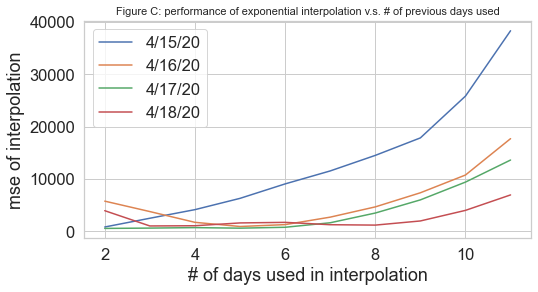

In [20]:
x = np.arange(11, 1, -1)
labels = ['4/15/20', '4/16/20', '4/17/20', '4/18/20']
plt.figure(figsize=(8, 4))
for i in range(4):
    plt.plot(x, results[i], label=labels[i])
plt.legend()
plt.ylabel("mse of interpolation")
plt.xlabel("# of days used in interpolation")
plt.title("Figure C: performance of exponential interpolation v.s. # of previous days used", fontsize=11);

Our first assumption follows from the **common exponential model for epidemic growth**. We take advantage of this and try to answer "which days in the time series can accurately predict the future" using exponential interpolation. More specifically, to generalize this assumption and reduce our search space, we **fit exponential curves for "n consecutive days earlier" ($n \in [2, 11]$).**

In [21]:
results

[[38285.24756287053,
  25819.94140263299,
  17846.844965505796,
  14510.320273548678,
  11544.732939517928,
  9070.47285335119,
  6314.276954803465,
  4161.163441568542,
  2519.443093081211,
  851.1078724010056],
 [17704.488586479663,
  10765.516107280713,
  7379.5534557015135,
  4686.816391233828,
  2730.5572690721815,
  1303.5988961571536,
  948.0088682990281,
  1743.1088289294564,
  3794.997094648453,
  5784.549847621325],
 [13626.036200996768,
  9416.257717735434,
  6023.611215808029,
  3514.9756683769333,
  1658.6922774102868,
  798.5137952842675,
  628.8950452665757,
  734.2707983926412,
  640.5454020072356,
  580.8426131360369],
 [6971.202738965814,
  4023.1203965566156,
  2003.898266704859,
  1212.1586187397197,
  1287.9287967038435,
  1735.9267688954167,
  1627.5788745737757,
  1093.259278994208,
  1049.7701682916752,
  3962.563621160481]]

#### Distribution Observation

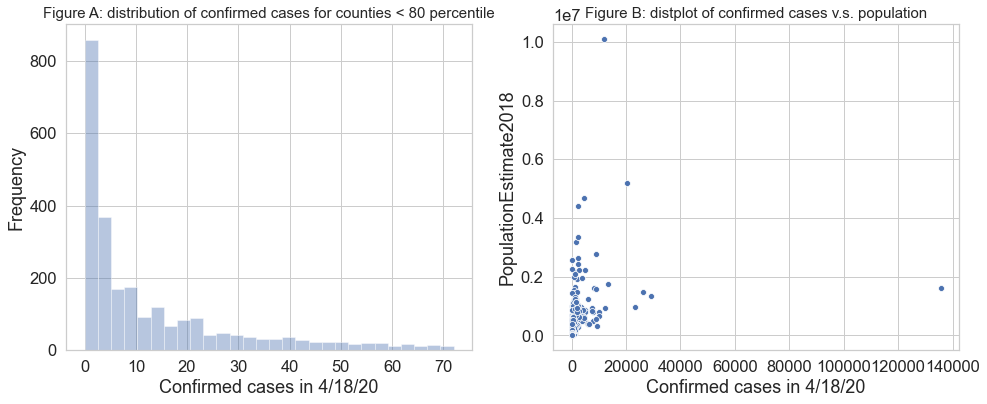

In [22]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.distplot(y[y < np.percentile(y, 80)], kde=False)
plt.xlabel("Confirmed cases in 4/18/20")
plt.ylabel("Frequency")
plt.title("Figure A: distribution of confirmed cases for counties < 80 percentile", fontsize=15);

plt.subplot(1, 2, 2)
sns.scatterplot(x="4/18/20", y="PopulationEstimate2018", data=data)
plt.xlabel("Confirmed cases in 4/18/20")
plt.title("Figure B: distplot of confirmed cases v.s. population", fontsize=15);

- In figure A, we plot out the **distribution of confirmed cases for counties within lower 80 percentiles**. It shows how left-skewed the distribution is as **80\% of counties have less than 80 cases and more than $\frac{1}{3}$ of counties have less than 10**. 
- Figure B gives us a more complete view of the distribution of populations and confirmed cases, as we can see **the clusters of points near the origin and some "outlier-like" points far away**, which helps us greatly in the downstream model selection. We also didn't find a strong correlation between population size and the confirmed case. 

### 3. LassoCV Automated Feature Selection

In [23]:
sfm = SelectFromModel(LassoCV(normalize=True)).fit(X, y)

feature_imp_df = pd.DataFrame({"col_name": X.columns, "imp": sfm.estimator_.coef_})
feature_imp_df.sort_values(by="imp", ascending=False)[:20]

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6461634.685806999, tolerance: 2265056.071871848
  positive)


,col_name,imp
5,1/24/20,2.323859e+02
13,2/1/20,2.253467e+02
60,3/19/20,8.781618e-01
111,dem_to_rep_ratio,2.839159e-01
84,4/12/20,2.406786e-01
89,4/17/20,1.788811e-01
87,4/15/20,1.723717e-01
83,4/11/20,1.652801e-01
88,4/16/20,1.527696e-01
85,4/13/20,1.512578e-01


#### Feature Correlation Visualization Heatmap

In [24]:
lasso_features = ['dem_to_rep_ratio', 'PopulationDensityperSqMile2010', 'PopFmle25-292010', '4/18/20']
extra_t_features = ['PopulationEstimate2018', 'stay at home', 
                    'Mortality_Rate', 'Testing_Rate', 'People_Hospitalized', 
                    'Incident_Rate', 'People_Tested', 'StrokeMortality','PopFmle65-742010',
                    'PopMale75-842010', 'PopFmle75-842010', 
                    'PopFmle45-542010','PopMale55-592010', 'PopFmle55-592010', 'PopMale60-642010',
                    'PopFmle60-642010',
                    'PopMale75-842010', 'PopFmle75-842010',
                    '3-YrMortalityAge55-64Years2015-17',
                    '3-YrMortalityAge65-74Years2015-17',
                    '3-YrMortalityAge75-84Years2015-17', '3-YrMortalityAge85+Years2015-17',]
heat_features = lasso_features + extra_t_features

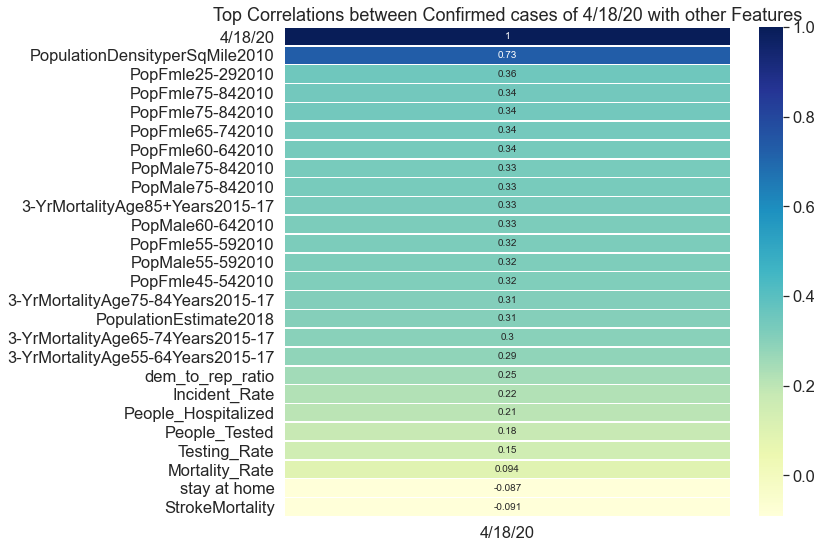

In [25]:
heat_df = all_in_1[heat_features]

plt.figure(figsize=(10, 9))
plot = sns.heatmap(heat_df.corr()[['4/18/20']].sort_values(by=['4/18/20'],ascending=False),
            cmap="YlGnBu", linewidths=.5, annot=True, annot_kws={"size": 10})
plot.set_title('Top Correlations between Confirmed cases of 4/18/20 with other Features');

## Model

In [26]:
features = ['4/15/20',
 '4/16/20',
 '4/17/20',
 'dem_to_rep_ratio',
 'public schools',
 'FracMale2017',
 'DiabetesPercentage',
 'People_Tested',
 'HeartDiseaseMortality',
 ]

### 1. Simple Regressors (LinearRegression v.s. DecisionTree vs. KNN Regressor)

#### Feature Augmentation Attempt using KNN Regressor

In [27]:
def dist_metric(loc1, loc2):
    lat1, lon1, lat2, lon2  = loc1[0], loc1[1], loc2[0], loc2[1]
    p = 0.017453292519943295 # Pi / 180
    a = 0.5 - np.cos((lat2 - lat1) * p) / 2 + np.cos(lat1 * p) * np.cos(lat2 * p) * \
    (1 - np.cos((lon2 - lon1) * p)) / 2
    return 12742 * np.arcsin(a ** 2) # 12742 = 2 * R

In [28]:
X_KNN, y_KNN = data.loc[:, ['Lat_x', 'Long_']], data['4/18/20']

neigh = KNeighborsRegressor(n_neighbors=2, weights = 'distance', metric = dist_metric)
neigh.fit(X_KNN, y_KNN)

KNeighborsRegressor(algorithm='auto', leaf_size=30,
                    metric=<function dist_metric at 0x1201d9e60>,
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='distance')

In [29]:
# setting up a dictionary with {county_index: list of its K Nearest Neighbours} Pairings
clusters = neigh.kneighbors()[1]
neighbour_dict = {i: clusters[i] for i in X.index}

In [30]:
# ref_pop is the poplation of the county being referenced to, neigh_pop is the population of one of its 
# neighbor counties counts, neigh_pops are np arrays, ref_pop is is an integer
def normalize_by_pop(stat_mat, neigh_pops, ref_pop):
    factors = [ref_pop/n_pop for n_pop in neigh_pops]
    weighted_sums = stat_mat @ factors
    return list(weighted_sums / len(neigh_pops))
 

f = ['4/15/20','4/16/20','4/17/20']
f_new = ['4/15/20_neigh_nor','4/16/20_neigh_nor','4/17/20_neigh_nor']

new_feature_list = []

for i in X.index:
    neigh_id = neighbour_dict.get(i)

    ref_pop = X.loc[i, 'PopulationEstimate2018']
    neigh_pops = X.loc[neigh_id, 'PopulationEstimate2018']
    stat_matrix = np.transpose(X.loc[neigh_id, f]) # a len(f) by num_neigh matrix
    
    new_feature_list.append(normalize_by_pop(stat_matrix, neigh_pops, ref_pop))

new_feature_df = pd.DataFrame(np.array(new_feature_list), columns=f_new)

X_new = pd.concat([X, new_feature_df], axis=1)

#### Train-test Split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.1, random_state=42)

X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_new[features + f_new], y, test_size=0.1, random_state=42)


#### Overall MSE of LinearRegressor and TreeRegresso

In [32]:
linear_regr = LinearRegression(normalize=True)
linear_regr.fit(X_train, y_train)

tree_regr = DecisionTreeRegressor(max_depth=20, random_state=42)
tree_regr.fit(X_train, y_train)

linear_regr_KNN = LinearRegression(normalize=True)
linear_regr_KNN.fit(X_train_aug, y_train_aug)

tree_regr_KNN = DecisionTreeRegressor(max_depth=20, random_state=42)
tree_regr_KNN.fit(X_train_aug, y_train_aug)


linear_pred = np.round(np.maximum(0, linear_regr.predict(X_test)))
linear_mse = mse(linear_pred, y_test)

tree_pred = np.round(tree_regr.predict(X_test))
tree_mse = mse(tree_pred, y_test)

KNN_linear_pred = np.round(np.maximum(0, linear_regr_KNN.predict(X_test_aug)))
KNN_linear_mse = mse(KNN_linear_pred, y_test_aug)

KNN_tree_pred = np.round(tree_regr_KNN.predict(X_test_aug))
KNN_tree_mse = mse(KNN_tree_pred, y_test_aug)


print(f"Linear mse: {linear_mse}, Tree mse: {tree_mse}")
print(f"Linear_KNN mse: {KNN_linear_mse}, Tree_KNN mse: {KNN_tree_mse}")

Linear mse: 56.02229299363057, Tree mse: 561.0859872611464
Linear_KNN mse: 119.93949044585987, Tree_KNN mse: 328.45222929936307


- We can see that that the KNN Algorithm act as a mediator for the algorithms. It improves the Desion Tree Model quite significantly, by introducing noise, nuetralizing overfitting.
- Our data, concluded from EDA, can be better modeled by a linear model. Thus, KNN adds noise to it.

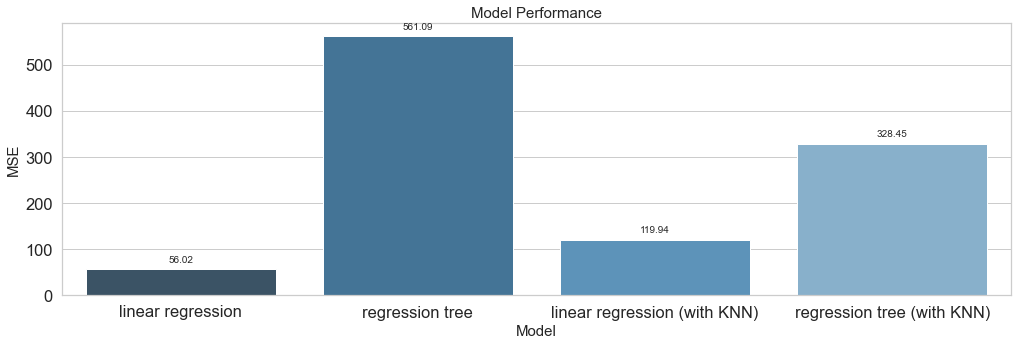

In [33]:
df = pd.DataFrame([["linear regression", linear_mse],
                   ['regression tree', tree_mse],
                   ["linear regression (with KNN)", KNN_linear_mse],
                  ["regression tree (with KNN)", KNN_tree_mse]],
                  columns = ["model", "MSE"])


fig, ax = plt.subplots(figsize=(17, 5))

sns.barplot(x="model", y="MSE", palette="Blues_d", data=df)

plt.xlabel('Model', fontsize = 15)
plt.ylabel('MSE', fontsize = 15)
plt.title('Model Performance', fontsize = 15)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
             (p.get_x() + p.get_width() / 2,
              p.get_height()), 
             ha = 'center', 
             va = 'center', 
             xytext = (0, 10), 
             textcoords = 'offset points')

#### Check the mse for prediction of counties with small/middle/large confirmed cases

In [34]:
per_25, per_75 = np.percentile(y_test, 25), np.percentile(y_test, 75)

small_indices = np.argwhere(y_test < per_25).flatten()
middle_indices = np.argwhere((y_test >= per_25) & (y_test < per_75)).flatten()
big_indices = np.argwhere(y_test >= per_75).flatten()

for indices in [small_indices, middle_indices, big_indices]:
    a = y_test.to_numpy()[indices]
    
    #Linear
    b = linear_pred[indices]
    # Decision Tree
    c = tree_pred[indices]
    #Linear + KNN
    d = KNN_linear_pred[indices]
    # Decision Tree + KNN
    e = KNN_tree_pred[indices]
    
    print(f"Linear mse: {mse(a, b)}, Tree mse: {mse(a, c)}") 
    print(f"Linear_KNN mse: {mse(a, d)}, Tree_KNN mse: {mse(a, e)}")

Linear mse: 5.830985915492958, Tree mse: 0.14084507042253522
Linear_KNN mse: 3.9859154929577465, Tree_KNN mse: 0.1267605633802817
Linear mse: 16.00609756097561, Tree mse: 73.70731707317073
Linear_KNN mse: 11.981707317073171, Tree_KNN mse: 72.6951219512195
Linear mse: 184.20253164556962, Tree mse: 2077.0
Linear_KNN mse: 448.26582278481015, Tree_KNN mse: 1154.4683544303798


/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


- We can see the above tendency is more obvious data is bigger. This give a nice intuition for fine tuning the final model: applying KNN to the larger percentile of data might be benefitial.

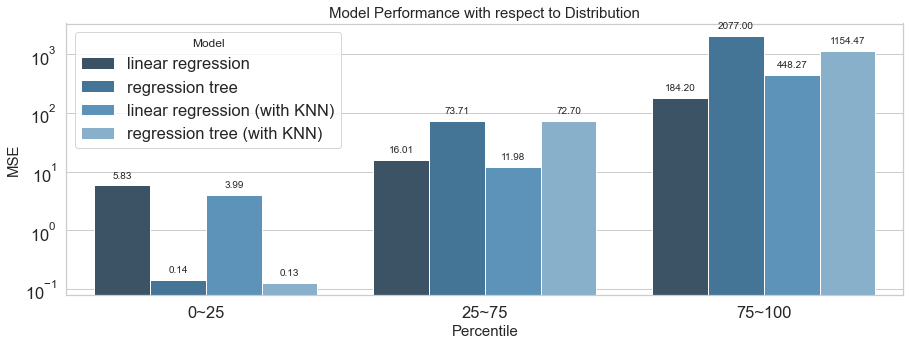

In [35]:
df = pd.DataFrame([["linear regression", "0~25", 5.830985915492958],
                   ["linear regression", "25~75", 16.00609756097561],
                   ["linear regression", "75~100", 184.20253164556962],
                   
                   ['regression tree', "0~25", 0.14084507042253522],
                  ['regression tree', "25~75", 73.70731707317073],
                  ['regression tree', "75~100", 2077.0],
                   
                   ["linear regression (with KNN)", "0~25", 3.9859154929577465],
                   ["linear regression (with KNN)", "25~75", 11.981707317073171],
                   ["linear regression (with KNN)", "75~100", 448.26582278481015],
                   
                   ['regression tree (with KNN)', "0~25", 0.1267605633802817],
                  ['regression tree (with KNN)', "25~75", 72.6951219512195],
                  ['regression tree (with KNN)', "75~100", 1154.4683544303798]
                  ],
                  columns = ["Model", "percentile", "MSE"])

fig, ax = plt.subplots(figsize=(15, 5))
ax.set(yscale="log")
sns.barplot(x = "percentile", y = "MSE", hue = "Model", palette="Blues_d", data=df)

plt.xlabel('Percentile', fontsize = 15)
plt.ylabel('MSE', fontsize = 15)
plt.title('Model Performance with respect to Distribution', fontsize = 15)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
             (p.get_x() + p.get_width() / 2,
              p.get_height()), 
             ha = 'center', 
             va = 'center', 
             xytext = (0, 10), 
             textcoords = 'offset points')



### 2. Final Regressor

In [36]:
class finalRegressor(object):
    def __init__(self, threshold=50, depth=11, forest=False, randstate=42):
        self.thres = threshold
        if forest:
            self.tree_regr = RandomForestRegressor(n_estimators=50, max_depth=depth, random_state=randstate)
        else:
            self.tree_regr = DecisionTreeRegressor(max_depth=depth, random_state=randstate)
        self.linear_regr = LinearRegression(normalize=True)
    
    def fit(self, X_train, y_train):
        self.tree_regr.fit(X_train, y_train)
        self.linear_regr.fit(X_train, y_train)
        self.thres_val = np.percentile(y_train, self.thres)
    
    def predict(self, X_test):
        self.linear_pred = np.maximum(self.linear_regr.predict(X_test), 0)
        self.tree_pred = self.tree_regr.predict(X_test)
        self.cond_vec = ((self.linear_pred + self.tree_pred) / 2) < self.thres_val
        return np.round(self.tree_pred * self.cond_vec + self.linear_pred * ~self.cond_vec)


##### Using test data to tune the max_depth for DecisionTree

In [37]:
depth_results = []
small_indices = np.argwhere(y_test < 100).flatten()

for depth in range(3, 30):
    dt = DecisionTreeRegressor(max_depth=depth)
    dt.fit(X_train, y_train)
    a, b = dt.predict(X_test)[small_indices], y_test.to_numpy()[small_indices]
    depth_results.append(mse(a, b))

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


In [38]:
optimal_max_depth = np.argmin(depth_results) + 3
optimal_max_depth

11

(0.0, 500.0)

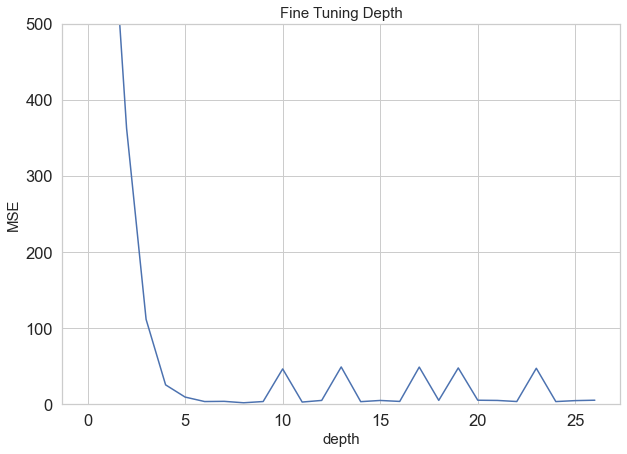

In [39]:
plt.figure(figsize=(10, 7))

plt.plot(depth_results)

plt.xlabel('depth', fontsize = 15)
plt.ylabel('MSE', fontsize = 15)
plt.title('Fine Tuning Depth', fontsize = 15)
plt.ylim(0, 500)

##### Using 5-fold Cross Validation to tune the best threshold of our final predictor

In [40]:
kf = KFold(n_splits=5)
best_thres, best_val = None, float('inf')

for thres in range(20, 100):
    cv_result = []
    for train_index, test_index in kf.split(X_train):
        final_regr = finalRegressor(thres)
        final_regr.fit(X_train.iloc[train_index], y_train.iloc[train_index])
        final_pred = final_regr.predict(X_train.iloc[test_index])
        cv_result.append(mse(final_pred, y_train.iloc[test_index]))
    if best_val > np.mean(cv_result):
        best_val = np.mean(cv_result)
        best_thres = thres

In [41]:
final_predictor = finalRegressor(best_thres) 
final_predictor.fit(X_train, y_train)
best_mse = mse(y_test, final_predictor.predict(X_test))
print("Our integrated model, after fine-tuning, achieves the MSE of " + str(best_mse) + " on testing set")

Our integrated model, after fine-tuning, achieves the MSE of 48.503184713375795 on testing set


================================================================================================================
# END PROJECT